## Functions

In [26]:
from anchor import utils

import time
import csv
import newlime_utils

from tabulate import tabulate

def sample(index, dataset, dataset_name, dataset_folder, write_file=False):
    trg, label, tab = newlime_utils.get_trg_sample(index, dataset, dataset_name)
    
    print('Prediction:', dataset.class_names[rf.predict(trg.reshape(1, -1))[0]])
    print('True:      ', dataset.class_names[dataset.labels_test[index]])
    print(tabulate(tab))
    if write_file:
        with open('img/%s/%05d-instance.csv' % (dataset_name, index), 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows([['feature', 'value']])
            writer.writerows(tab)
    return trg, label

In [30]:
from lime import explanation
from lime import lime_tabular

def lime_original(trg, pred_label):
    lime_explainer = lime_tabular.LimeTabularExplainer(
        dataset.train,
        feature_names=dataset.feature_names,
        class_names=dataset.class_names,
        discretize_continuous=False)
    lime_exp = lime_explainer.explain_instance(
        trg, rf.predict_proba, num_features=5, top_labels=1)
    # lime_exp.show_in_notebook(show_table=True, show_all=True)
    weights = [0] * len(dataset.feature_names)
    for t in lime_exp.local_exp[pred_label]:
        weights[t[0]] = t[1] * (pred_label * 2 - 1)
    newlime_utils.plot_weights(weights, dataset.feature_names)

In [7]:
from anchor import anchor_tabular

def anchor_original(trg, threshold=0.85):
    anchor_explainer = anchor_tabular.AnchorTabularExplainer(
        dataset.class_names,
        dataset.feature_names,
        dataset.train,
        dataset.categorical_names)
    anchor_exp = anchor_explainer.explain_instance(
        trg, rf.predict, threshold)

    print('Threshold:  %.2f' % threshold)
    # print('Prediction:', anchor_explainer.class_names[rf.predict(trg.reshape(1, -1))[0]])
    print('Anchor:     %s' % (' AND '.join(anchor_exp.names())))
    print('Precision:  %.2f' % anchor_exp.precision())
    print('Coverage:   %.2f' % anchor_exp.coverage())

In [22]:
import newlime_base
import newlime_tabular
import newlime_utils

def new_lime(trg, dataset, threshold, epsilon, beam_size, my_verbose):
    print("-----------")
    print("Threshold: ", threshold)
    anchor_explainer = newlime_tabular.NewLimeTabularExplainer(
        dataset.class_names,
        dataset.feature_names,
        dataset.train,
        dataset.categorical_names)
    anchor_exp, surrogate_model = anchor_explainer.explain_instance(
        trg, rf.predict, threshold=threshold, epsilon=epsilon, beam_size=10, my_verbose=my_verbose)
    names = anchor_exp.names()
    multiline_names = []
    max_i = int(len(names) / 3)
    for i in range(max_i):
        triple = [names[i * 3], names[i * 3 + 1], names[i * 3 + 2]]
        multiline_names.append(' AND '.join(triple))
    if len(names) != max_i* 3:
        multiline_names.append(' AND '.join(names[max_i * 3:]))

    weights = list(surrogate_model['LogisticRegression'].weights.values())
    feat = dataset.feature_names
    rule = ' AND \n'.join(multiline_names)
    prec = anchor_exp.precision()
    cov = anchor_exp.coverage()
    print("Rule     : ", rule)
    print("Precision: ", prec)
    print("Coverage : ", cov)
    
    if weights == []:
        print("Error! Surrogate model has no weights!")
    else:
        newlime_utils.plot_weights(weights, feat, rule, prec, cov)

## Generating Explanations

In [11]:
dataset_folder = 'datasets/'
# dataset_name = 'recidivism'
dataset_name = 'adult'
# dataset_name = 'diabetes'
# dataset_name = 'default'
# dataset_name = 'lending'

dataset = utils.load_dataset(
    dataset_name, balance=True, dataset_folder=dataset_folder, discretize=True)

print(dataset.train.shape[0])
print(dataset.test.shape[0])
print(dataset.train.shape[0] + dataset.test.shape[0])

12545
1569
14114


In [12]:
import sklearn.ensemble

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
rf.fit(dataset.train, dataset.labels_train)

print('Train', sklearn.metrics.accuracy_score(
    dataset.labels_train, rf.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(
    dataset.labels_test, rf.predict(dataset.test)))

Train 0.9350338780390594
Test 0.8489483747609943


In [15]:
import random

i = random.randint(10, dataset.test.shape[0])

# adult
# 730, 956, 1196, 1522
# i = 1443 # --- Capital Gain = 2
i = 0

# recidivism
# i = 266
# i = 599

trg, trg_label = sample(i, dataset, dataset_name, dataset_folder)

Prediction: b'>50K'
True:       b'>50K'
--------------  --------------------------
Age             28.00 < Age <= 37.00 (1)
Workclass       Private (4)
Education       Bachelors (9)
Marital Status  Married-civ-spouse (2)
Occupation      Sales (12)
Relationship    Husband (0)
Race            White (4)
Sex             Male (1)
Capital Gain    0
Capital Loss    0
Hours per week  Hours per week > 45.00 (2)
Country         United-States (39)
Income          >50K (1)
--------------  --------------------------


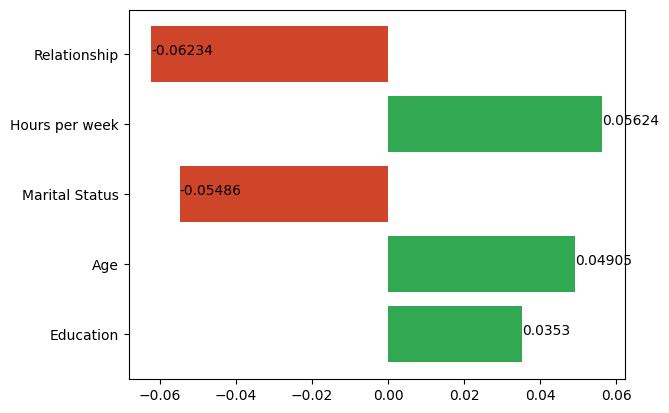

In [16]:
lime_original(trg, rf.predict([dataset.test[i]])[0])

write_file = False
if write_file:
    img_file = 'img/%s/%05d-LIME.png' % (dataset_name, i)
    plt.savefig(img_file, bbox_inches='tight')

Prediction: b'>50K'
True:       b'>50K'
--------------  --------------------------
Age             28.00 < Age <= 37.00 (1)
Workclass       Private (4)
Education       Bachelors (9)
Marital Status  Married-civ-spouse (2)
Occupation      Sales (12)
Relationship    Husband (0)
Race            White (4)
Sex             Male (1)
Capital Gain    0
Capital Loss    0
Hours per week  Hours per week > 45.00 (2)
Country         United-States (39)
Income          >50K (1)
--------------  --------------------------
-----------
Threshold:  0.7
Rule     :  Capital Loss = 0
Precision:  0.7329261521377013
Coverage :  0.9357


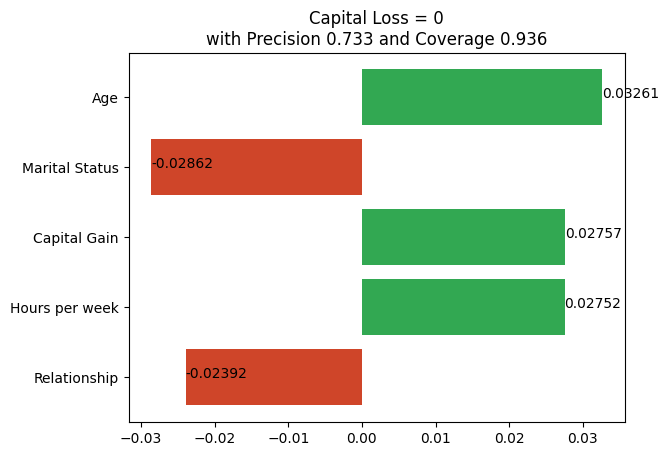

-----------
Threshold:  0.8
Rule     :  Education = Bachelors AND Relationship = Husband
Precision:  0.8309433962264151
Coverage :  0.1207


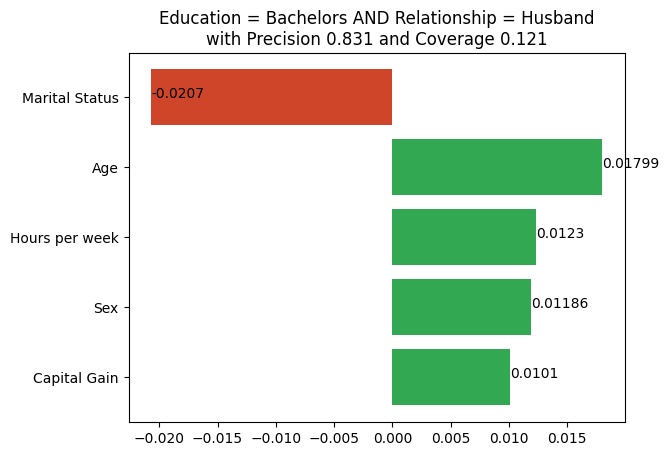

-----------
Threshold:  0.9
Rule     :  Sex = Male AND Education = Bachelors AND Occupation = Sales AND 
Marital Status = Married-civ-spouse
Precision:  0.9053497942386831
Coverage :  0.0209


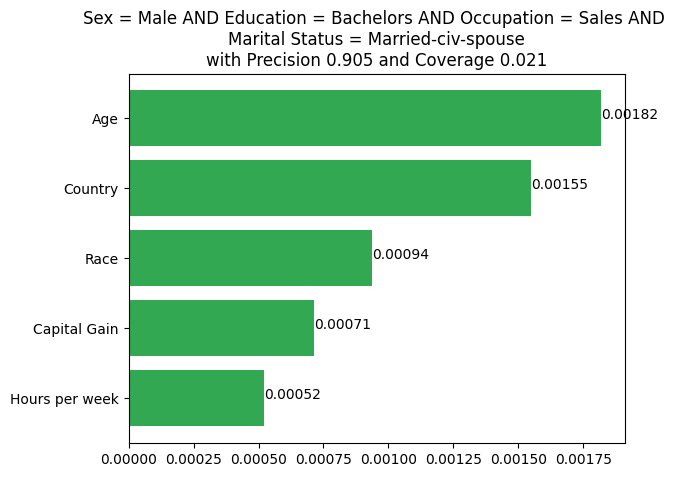

-----------
Threshold:  0.95
Rule     :  Occupation = Sales AND Education = Bachelors AND Relationship = Husband AND 
Race = White AND Marital Status = Married-civ-spouse
Precision:  0.9601769911504425
Coverage :  0.0155


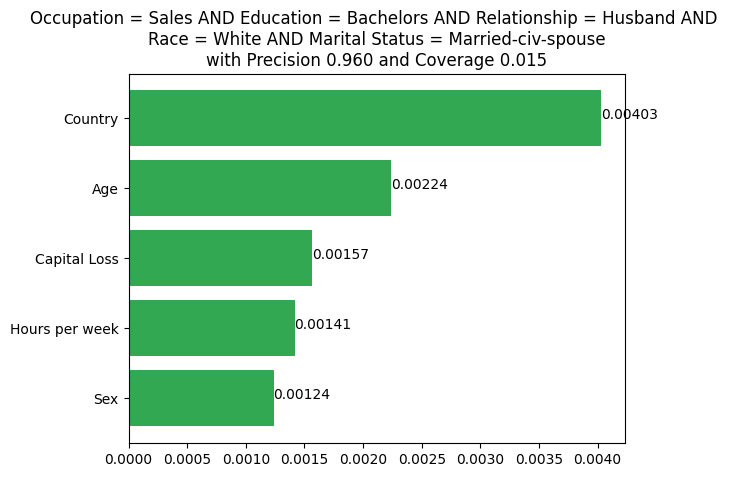

In [29]:
import importlib
importlib.reload(newlime_base)
importlib.reload(newlime_tabular)
importlib.reload(newlime_utils)
write_file = False

i = random.randint(10, dataset.test.shape[0])
i = 0
trg, trg_label = sample(i, dataset, dataset_name, dataset_folder)

for t in [0.70, 0.80, 0.90, 0.95]:
    new_lime(trg, dataset, threshold=t, beam_size=1, epsilon=0.1, my_verbose=True)
    if write_file:
        img_file = 'img/%s/%05d-%03d.png' % (dataset_name, i, t * 100)
        plt.savefig(img_file, bbox_inches='tight')

In [ ]:
i

In [ ]:
anchor_original(trg, threshold=0.80)